# Problem Statement

We have to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.25d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.50d.txt


## Importing Libraries

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud, STOPWORDS
import missingno as msno
import nltk
import re
import string
from keras.preprocessing.sequence import pad_sequences
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Importing Datasets

In [3]:
train = pd.read_csv(r'/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv(r'/kaggle/input/nlp-getting-started/test.csv')

In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
print(train.shape, test.shape)

(7613, 5) (3263, 4)


## Checking the missing values

In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

## Percentage of Missing Values

In [9]:
print("Percentage of keywords missing in train data:", (len(train[train['keyword'].isnull()==True])/train.shape[0])*100,"%")
print("Percentage of keywords missing in test data:", (len(test[test['keyword'].isnull()==True])/test.shape[0])*100,"%")
print("Percentage of location missing in train data:", (len(train[train['location'].isnull()==True])/train.shape[0])*100,"%")
print("Percentage of location missing in test data:", (len(test[test['location'].isnull()==True])/test.shape[0])*100,"%")

Percentage of keywords missing in train data: 0.8012610009194797 %
Percentage of keywords missing in test data: 0.796812749003984 %
Percentage of location missing in train data: 33.27203467752528 %
Percentage of location missing in test data: 33.86454183266932 %


As percentage of missing values for both keyword and location are equal for train and test data. So, it may be concluded that both are taken from the same sample

## Visualizing Most Repeated Words using WordCloud

In [10]:
stopwords = set(STOPWORDS)
def word_cloud(data, title=None):
    cloud = WordCloud(background_color = 'black',
                     stopwords = stopwords,
                     max_words = 200,
                     max_font_size = 40,
                     scale = 3).generate(str(data))
    fig = plt.figure(figsize=(15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.25)
        plt.imshow(cloud)
        plt.show()

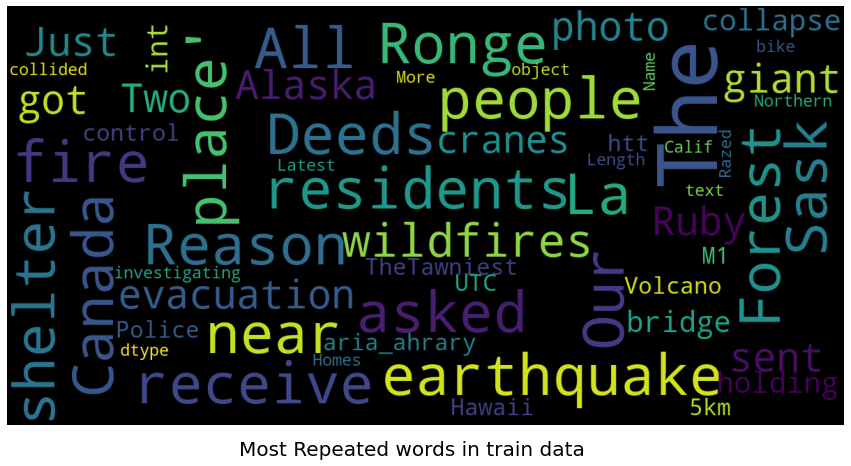

In [11]:
word_cloud(train['text'],'Most Repeated words in train data')

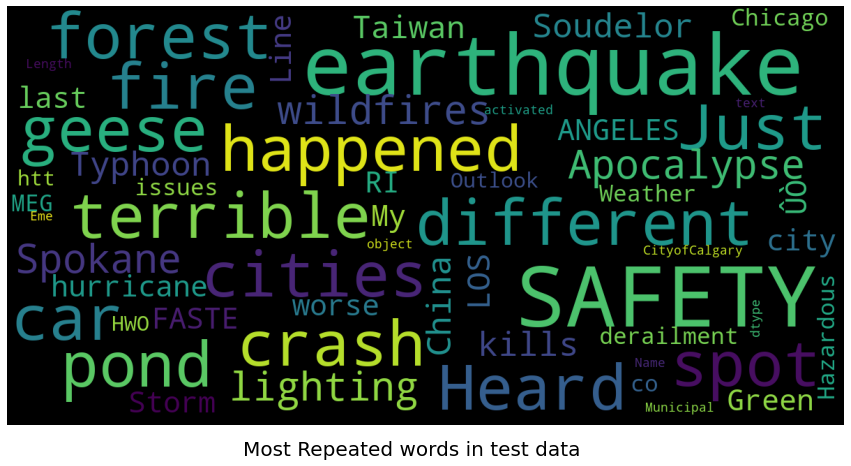

In [12]:
word_cloud(test['text'],'Most Repeated words in test data')

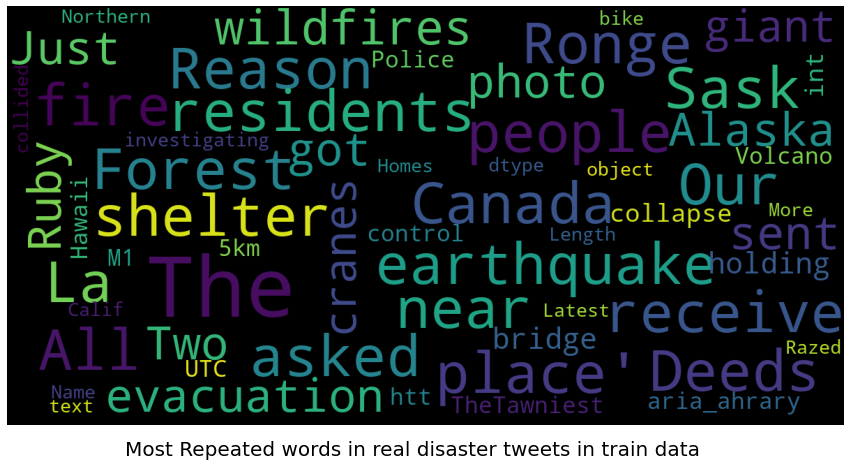

In [13]:
word_cloud(train[train['target']==1]['text'],'Most Repeated words in real disaster tweets in train data')

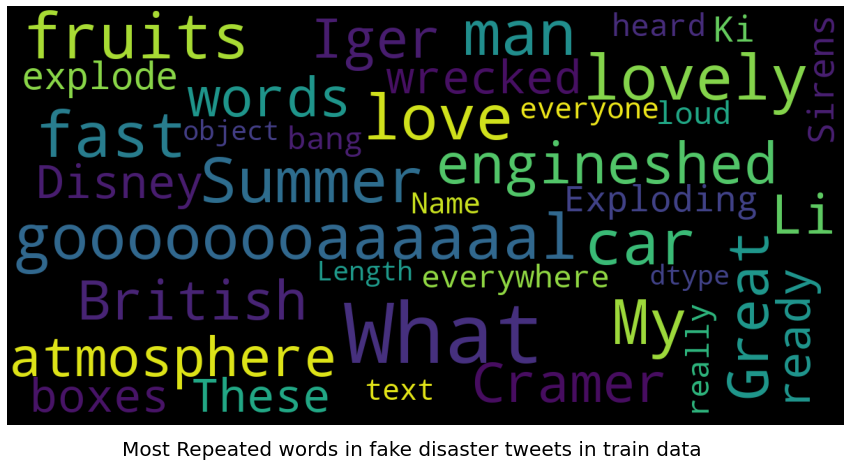

In [14]:
word_cloud(train[train['target']==0]['text'],'Most Repeated words in fake disaster tweets in train data')

# Visualizing Counts for each categories of tweet

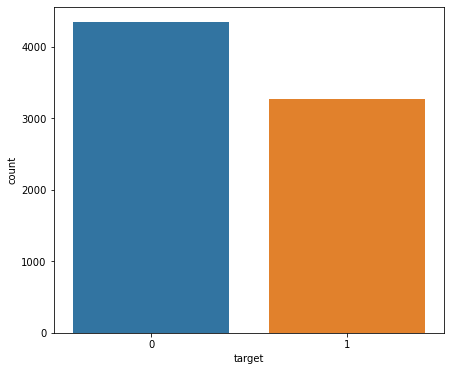

In [15]:
plt.figure(figsize=(7,6))
sns.countplot(train['target'])

Looks like a Balanced Dataset

## Visualizing keyword repitition in each disaster and non-disaster tweets

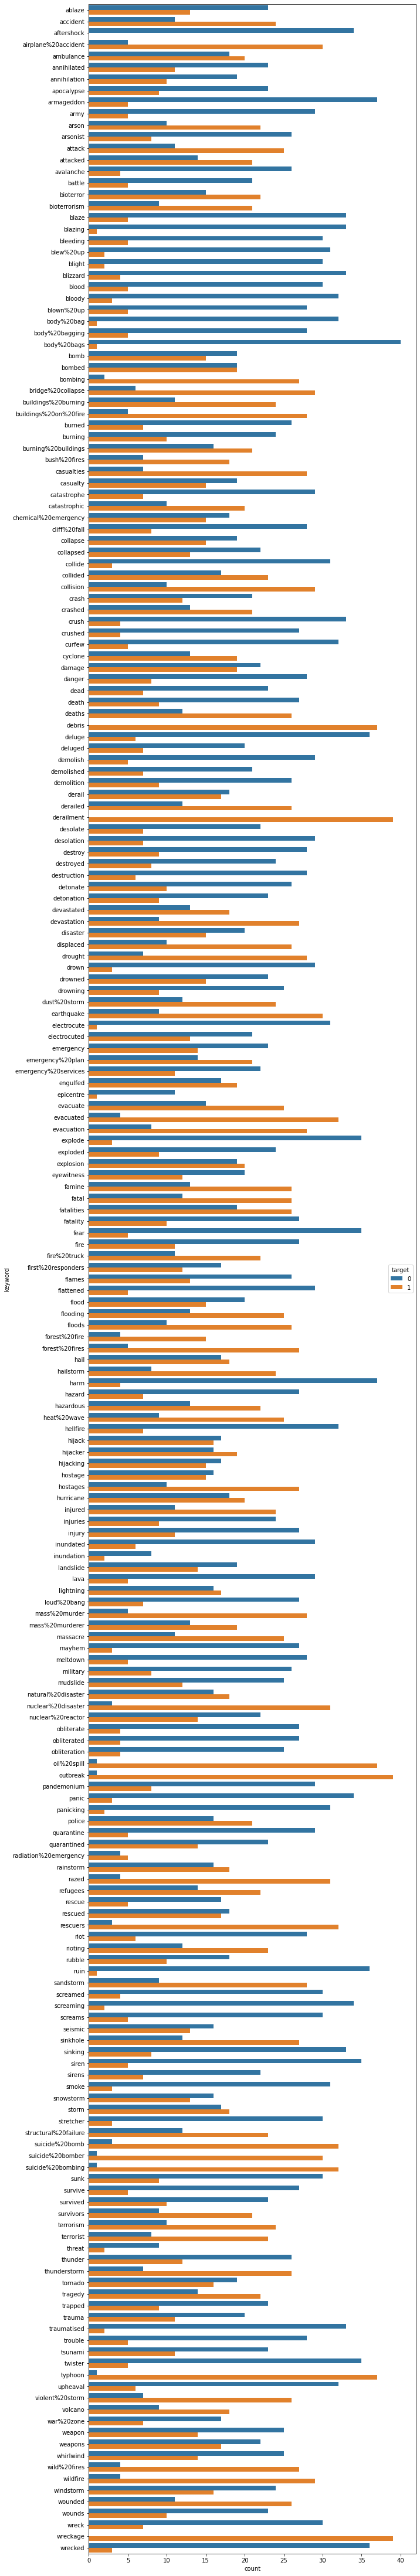

In [16]:
plt.figure(figsize=(10,80))
sns.countplot(y = 'keyword', hue = 'target', data = train)

## Data Cleaning

### Number of characters in a tweet

Text(0.5, 0.98, 'Characters in tweets')

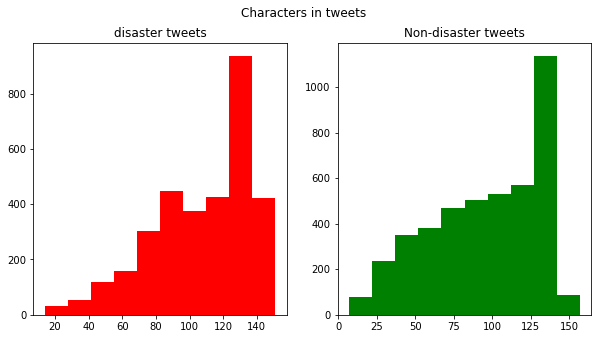

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Characters in tweets')

### Number of words in a tweet

Text(0.5, 0.98, 'Words in a tweet')

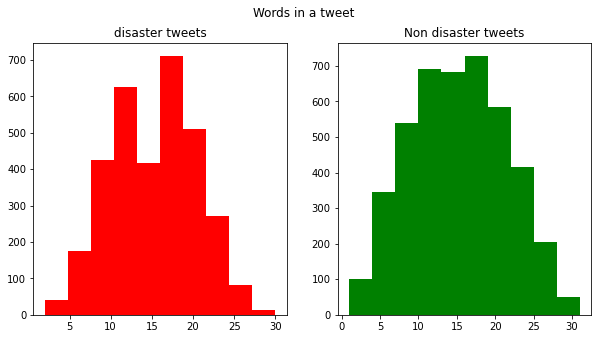

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_words = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_words, color='red')
ax1.set_title('disaster tweets')
tweet_words = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_words, color='green')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a tweet')

### Average Word Length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

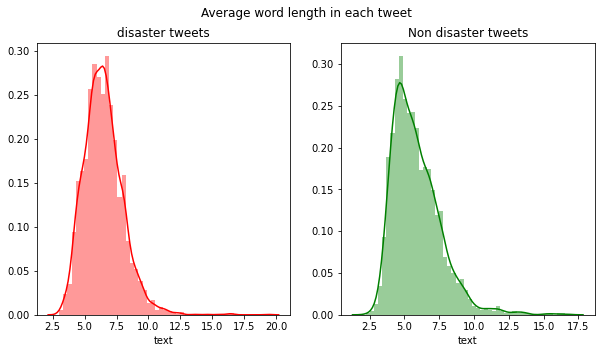

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
tweet_words = train[train['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(tweet_words.map(lambda x: np.mean(x)), color='red')
plt.title('disaster tweets')
plt.subplot(1,2,2)
tweet_words = train[train['target']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(tweet_words.map(lambda x: np.mean(x)), color='green')
plt.title('Non disaster tweets')
plt.suptitle('Average word length in each tweet')

## Data Cleaning

### Removing emojis

In [20]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [21]:
train['text'] = train['text'].apply(lambda x: remove_emoji(x))
test['text'] = test['text'].apply(lambda x: remove_emoji(x))

In [22]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [23]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [24]:
def clean_data(data):
    # Removing urls
    data = re.sub(r'https?://\S+|www\.\S+',' ', data)
    # Remove Punctutaions
    t = [w for w in data if w not in string.punctuation]
    data = ''.join(t)
    # Remove Stopwords
    t = [w for w in data.split() if w not in stopwords]
    data = ' '.join(t)
    # Remove numbers from text'
    data = re.sub(r'\d+',' ', data)
    # Lowercasing the data
    data = data.lower()
    # Removing everthing other than alphabets
    data = re.sub('[^a-zA-Z]',' ', data)
    # Remove html tags
    data = re.sub(r'<.*?>',' ', data)
    # Removing whitespace characters
    data = re.sub(r'\s',' ',data)
    data = re.sub(r' +',' ',data)
    return data

In [25]:
train['text'] = train['text'].apply(lambda x: clean_data(x))
test['text'] = test['text'].apply(lambda x: clean_data(x))

In [26]:
print(train['text'][0])

our deeds reason earthquake may allah forgive us


In [27]:
disaster_tweets = train[train['target']==1]
non_disaster_tweets = train[train['target']==0]

## N-gram exploration

In [28]:
def get_top_n_words(corpus, ngram_range = (1,1), n= None):
    vec = CountVectorizer(ngram_range = ngram_range, stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    word_freq = [(word, sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)
    return word_freq[:n]

## Distribution of top unigrams

<Figure size 432x288 with 0 Axes>

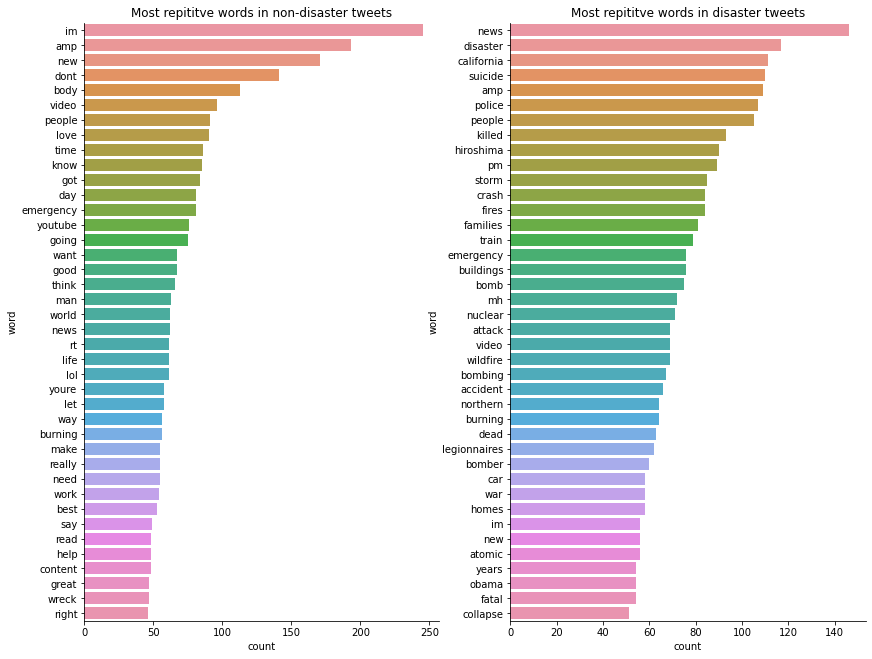

In [29]:
neg_unigram = get_top_n_words(disaster_tweets['text'],(1,1),40)
pos_unigram = get_top_n_words(non_disaster_tweets['text'],(1,1),40)

df1 = pd.DataFrame(pos_unigram, columns = ['word','count'])
df2 = pd.DataFrame(neg_unigram, columns = ['word','count'])

plt.tight_layout()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,11))
sns.barplot(x = 'count' , y = 'word', data = df1, orient = 'h',ax = ax1)
ax1.set_title('Most repititve words in non-disaster tweets')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df2, orient = 'h',ax = ax2)
ax2.set_title('Most repititve words in disaster tweets')
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(False)

## Distribution of top bigrams

<Figure size 432x288 with 0 Axes>

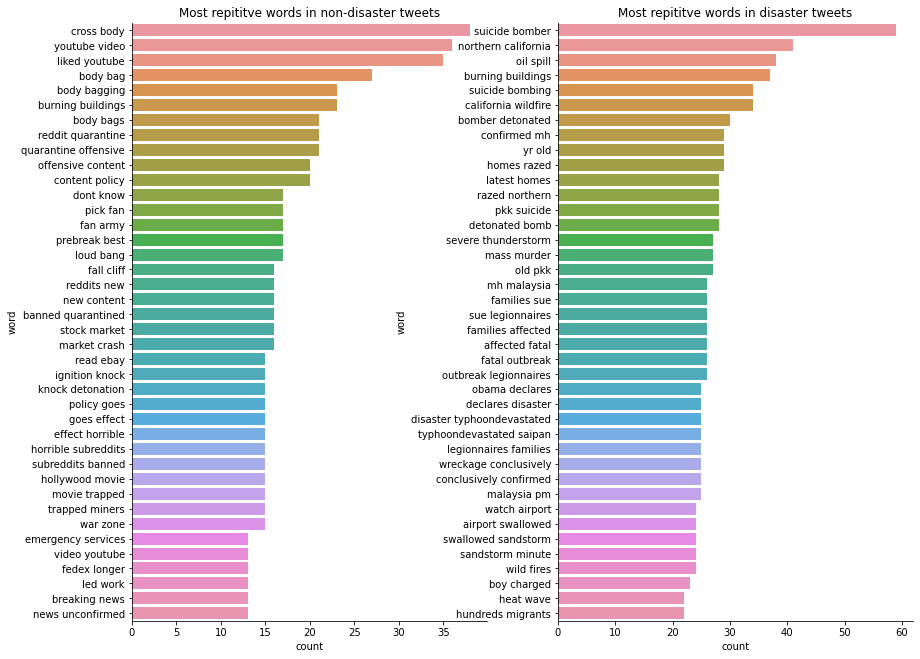

In [30]:
neg_unigram = get_top_n_words(disaster_tweets['text'],(2,2),40)
pos_unigram = get_top_n_words(non_disaster_tweets['text'],(2,2),40)

df1 = pd.DataFrame(pos_unigram, columns = ['word','count'])
df2 = pd.DataFrame(neg_unigram, columns = ['word','count'])

plt.tight_layout()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,11))
sns.barplot(x = 'count' , y = 'word', data = df1, orient = 'h',ax = ax1)
ax1.set_title('Most repititve words in non-disaster tweets')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df2, orient = 'h',ax = ax2)
ax2.set_title('Most repititve words in disaster tweets')
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(False)

## Distribution of top trigrams

<Figure size 432x288 with 0 Axes>

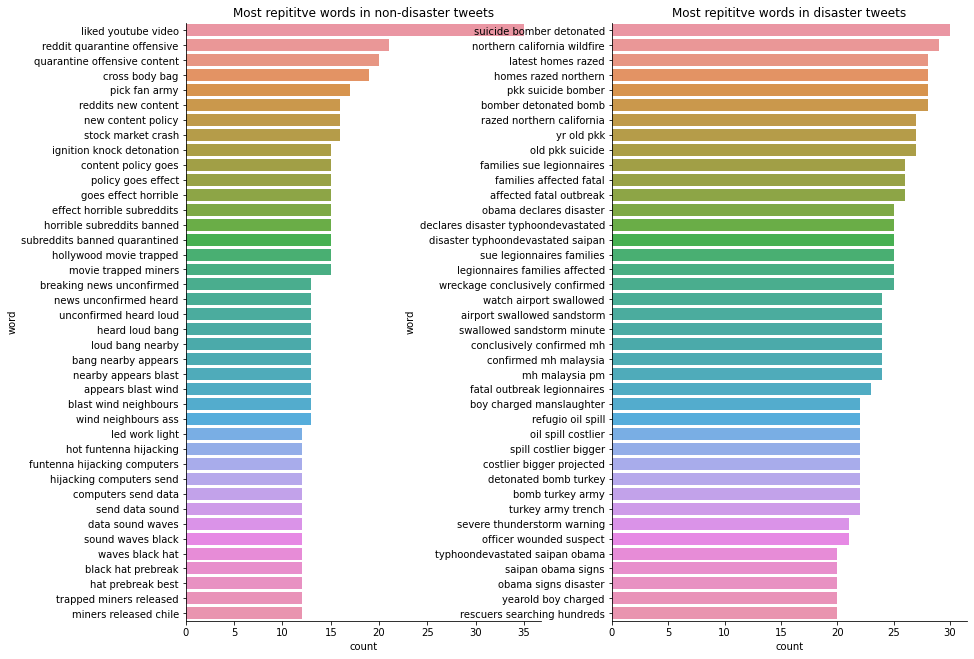

In [31]:
neg_unigram = get_top_n_words(disaster_tweets['text'],(3,3),40)
pos_unigram = get_top_n_words(non_disaster_tweets['text'],(3,3),40)

df1 = pd.DataFrame(pos_unigram, columns = ['word','count'])
df2 = pd.DataFrame(neg_unigram, columns = ['word','count'])

plt.tight_layout()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,11))
sns.barplot(x = 'count' , y = 'word', data = df1, orient = 'h',ax = ax1)
ax1.set_title('Most repititve words in non-disaster tweets')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df2, orient = 'h',ax = ax2)
ax2.set_title('Most repititve words in disaster tweets')
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(False)

## Number of words in a tweet after data cleaning

Text(0.5, 0.98, 'Words in a tweet')

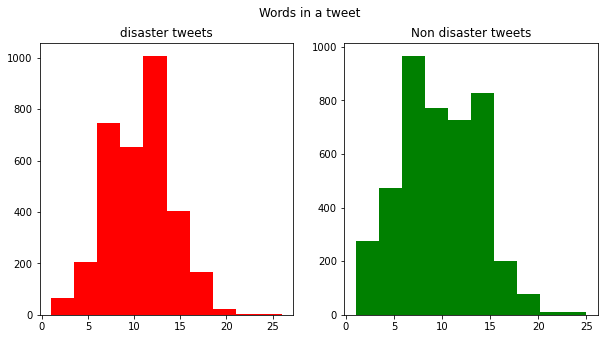

In [32]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_words = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_words, color='red')
ax1.set_title('disaster tweets')
tweet_words = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_words, color='green')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a tweet')

## Taking out the text and labels out of train and test dataset

In [33]:
train_text = []
train_labels = []
for i in range(len(train['text'])):
    train_text.append(str(train.iloc[i,3]))
    train_labels.append(train.iloc[i,4])
test_text = []
for i in range(len(test['text'])):
    test_text.append(str(test.iloc[i,3]))

## Initializing parameters

In [34]:
embedding_dim = 84
max_length = 20
vocab_size = 15000
padding_type = 'post'
trunc_type = 'post'

## Tokenizing the text

In [35]:
tokenizer = Tokenizer(oov_token='<oov>', num_words = vocab_size)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_text)

In [37]:
len(word_index)

16808

## Padding text to make it of same length

In [38]:
padded_train = pad_sequences(sequences, maxlen = max_length , padding = padding_type, truncating = trunc_type)

## Applying padding to test data

In [39]:
test_sequences = tokenizer.texts_to_sequences(test['text'])
padded_test = pad_sequences(test_sequences, maxlen = max_length , padding = padding_type, truncating = trunc_type)

## Make training labels as numpy array as it is expected for the training

In [40]:
y = np.array(train_labels)
y.shape

(7613,)

## Splitting training data into train and validation sets

In [41]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(padded_train,y,test_size=0.05,random_state=12)
print("Shape of X_train: " + str(X_train.shape))
print("Shape of y_train: " + str(len(y_train)))
print("Shape of X_val: " + str(X_val.shape))
print("Shape of y_val: " + str(len(y_val)))

Shape of X_train: (7232, 20)
Shape of y_train: 7232
Shape of X_val: (381, 20)
Shape of y_val: 381


## Using Pretrained Word Embeddings

In [42]:
def loadEmbeddingMatrix(emb_file):
    EMBEDDING_FILE = emb_file
    embed_size = 200
    embedding_index = dict()
    f = open(EMBEDDING_FILE)
    for line in f:
        value = line.split() # Split line tnto indexed Array
        word = value[0] # First index is word
        coef = np.asarray(value[1:],dtype = 'float32') # Rest all are word vectors
        embedding_index[word] = coef
    f.close()
    print('Loaded {} word vectors.'.format(len(embedding_index)))
    
    del(embedding_index['-0.29736'])
    all_emb = np.stack(list(embedding_index.values()))
    emb_mean, emb_std = all_emb.mean(), all_emb.std()
    
    nb_words = len(tokenizer.word_index) # Number of words in our dataset
    
    # We get the mean and standard deviation of embedding weights so that we could maintain the same statistics for random generated weights 
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    # We will fill the embedding matrix with the words common in both 
    embed_count = 0
    
    for word,i in tokenizer.word_index.items():
        i-=1
        # We will see if the word in glove's dictionary, if yes, get corresponding weights
        embedding_vector = embedding_index.get(word)
        # store this in embedding matrix which will be used for training later
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            embed_count += 1
        
    print('Total embedded', embed_count, 'common words')
    
    del(embedding_index)
    
    return embedding_matrix

In [43]:
embedding_matrix = loadEmbeddingMatrix('/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt')

Loaded 1193514 word vectors.
Total embedded 12647 common words


In [44]:
embedding_matrix.shape

(16808, 200)

## Initializing the Model

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index), embedding_matrix.shape[1], input_length = max_length, weights = [embedding_matrix],
                             trainable = False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=8, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           3361600   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            59648     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,421,777
Trainable params: 60,177
Non-trainable params: 3,361,600
_________________________________________

## Initializing the optimizer and metric 

In [46]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.RMSprop(lr=4*0.0001), metrics = ['acc'])

## Initializing Callback

In [47]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=1,
                              patience=2, min_lr=0.00000001)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_acc')>0.82):
            print('\nAccuracy Achieved')
            self.model.stop_training = True
            
callbacks = myCallback()

## Fitting the model

In [48]:
history = model.fit(X_train, y_train, epochs = 75, validation_data = (X_val, y_val),callbacks=[reduce_lr], verbose = 1)

Train on 7232 samples, validate on 381 samples
Epoch 1/75
7232/7232 [==============================] - 19s 3ms/sample - loss: 0.6821 - acc: 0.5543 - val_loss: 0.6568 - val_acc: 0.6089
Epoch 2/75
7232/7232 [==============================] - 15s 2ms/sample - loss: 0.6602 - acc: 0.6047 - val_loss: 0.6430 - val_acc: 0.6457
Epoch 3/75
7232/7232 [==============================] - 15s 2ms/sample - loss: 0.6329 - acc: 0.6524 - val_loss: 0.6118 - val_acc: 0.6693
Epoch 4/75
7232/7232 [==============================] - 14s 2ms/sample - loss: 0.6116 - acc: 0.6717 - val_loss: 0.5964 - val_acc: 0.6877
Epoch 5/75
7232/7232 [==============================] - 14s 2ms/sample - loss: 0.5927 - acc: 0.6858 - val_loss: 0.5964 - val_acc: 0.6693
Epoch 6/75
7232/7232 [==============================] - 14s 2ms/sample - loss: 0.5767 - acc: 0.7015 - val_loss: 0.5761 - val_acc: 0.7139
Epoch 7/75
7232/7232 [==============================] - 16s 2ms/sample - loss: 0.5584 - acc: 0.7188 - val_loss: 0.5711 - val_acc: 0

## Visualizing Training and validation sets loss and accuracy score

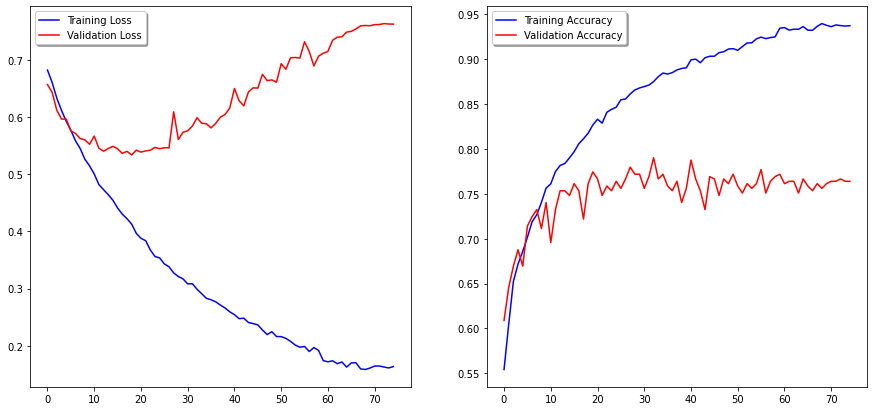

In [49]:
plt.figure(figsize=(15,7))
ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['loss'], color='b', label='Training Loss') 
ax1.plot(history.history['val_loss'], color='r', label = 'Validation Loss',axes=ax1)
legend = ax1.legend(loc='best', shadow=True)
ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['acc'], color='b', label='Training Accuracy') 
ax2.plot(history.history['val_acc'], color='r', label = 'Validation Accuracy')
legend = ax2.legend(loc='best', shadow=True)

## Predicting test data to output the tweet labels

In [50]:
y_pred = model.predict(padded_test)
model_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv('model_submission_new.csv', index=False)